<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/Copy_of_bert_finetuning_YouTube_clickbait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Sun Jul  4 14:49:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3MB 8.4MB/s 
     |████████████████████████████████| 1.6MB 8.6MB/s 
     |████████████████████████████████| 686kB 47.2MB/s 
     |████████████████████████████████| 358kB 48.5MB/s 
     |████████████████████████████████| 215kB 49.1MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 645kB 53.4MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 1.2MB 43.6MB/s 


#Imports

In [ ]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

In [ ]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_{bert_model_name}'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models/checkpoints'
model_checkpoint_path = os.path.join(checkpoint_root_path, 'my_checkpoint' )

stop_clickbait_checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/saved_models/checkpoints'
stop_clickbait_model_checkpoint_path = os.path.join(stop_clickbait_checkpoint_root_path, 'my_checkpoint' )


BATCH_SIZE = 32  
# Label categories
label_list = [0,1]
# maximum length of (token) input sequences
max_seq_len = 128
init_lr = 2e-5

epochs = 20

#Bert configs

In [ ]:
#@title "Model mappings"
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4'
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
}

In [ ]:
#@title "Bert pretrained model downlaod"
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_encoder')
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#Scripts

In [ ]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [ ]:
#@title "Utilities [Map bert preprocessing to Dataset]"
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_len, tokenizer=bert_tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32,tf.int32, tf.int32, tf.int32 ])
  input_ids.set_shape([max_seq_len])
  segment_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  label_id.set_shape([])

  x = {
       'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids':segment_ids
  }
  
  return (x, label_id)
  

In [ ]:
#@title "Utilities [Create Model Definition]"
def create_model():

 encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids"),
    input_mask=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,  name="input_mask"),
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids"),
)
 
 net = bert_layer(encoder_inputs)['pooled_output']

 net = tf.keras.layers.Dropout(0.2)(net)
 net = tf.keras.layers.Dense(384, activation='ReLU', name='dense_384')(net)
 net = tf.keras.layers.Dropout(0.2)(net)
 net = tf.keras.layers.Dense(192, activation='ReLU', name='dense_192')(net)
 net = tf.keras.layers.Dropout(0.4)(net)
 output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

 model = tf.keras.Model(
     encoder_inputs,
     outputs=output,
     name='prediction'
 )
 return model

#Read TFRecord data

In [ ]:
#@title  "Load files & Split"
#instantiate read_data utility
read_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()
num_train_examples = 500 * len(training_filenames)

len(filenames), len(training_filenames), len(validation_filenames), len(testing_filenames)

validation_steps = int(15572  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15572  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

#instantiate read_data utility
read_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
testing_filenames, _, _,_ = read_data.get_tfrec_files()
len(testing_filenames)

Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
With a batch size of 32, there will be 417 batches per training epoch and 69 batch(es) per validation run.
Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files


2

#Load TFRecord into TF Dataset

In [ ]:
# create the datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)

In [ ]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'faze clans most intense game yet leave a like if you enjoyed faze adapt merch snapchat adaptsnaps twitter instagram the faze house rain apex teeqo temperrr blaziken gamma labs discount code adapt scuf discount code adapt watch all my videos', class : 1, label : b'clickbaits'
text : b'iphone and plus photo shoot on location in iceland apple s latest iphones are out in the world and the camera is one of their most talked about features so to see what the new devices can really do travel photographer austin mann went to iceland on a week long photography adventure he s been shooting in some incredible places in incredibly difficult conditions he s put both iphone and iphone plus to their ultimate test see more on the verge see more on austin s site subscribe check out our full video catalog visit our playlists like the verge on facebook follow on twitter follow on instagram read more', class : 0, label : b'nonclickbaits'
text : b'gta new dlc new super cars release tomorrow more g

In [ ]:
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))

#Modeling

##Bert preprocessing

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = train_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_data = get_batched_dataset(train_data, train=True)

  # valid
  val_data = val_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  val_data = get_batched_dataset(val_data)

  # test
  test_data = test_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_data = get_batched_dataset(test_data)
  

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#Build classifier

In [ ]:
classifier_model = create_model()
classifier_model.summary()

Model: "prediction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_encoder (KerasLayer)       {'pooled_output': (N 109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]    

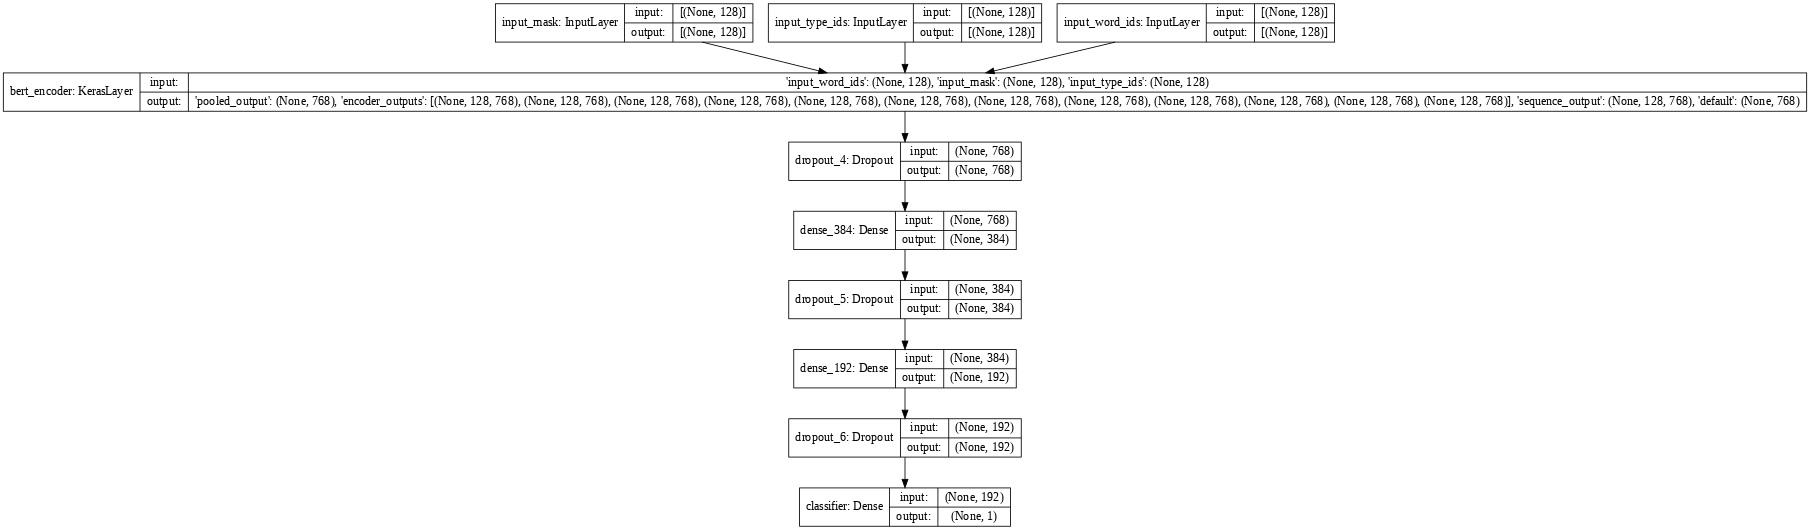

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        verbose=1, 
                                        patience=5, 
                                        mode='min', 
                                        restore_best_weights=True)

mcb = tf.keras.callbacks.ModelCheckpoint(
       filepath=model_checkpoint_path,
       save_weights_only=True,
       monitor='val_prc',
       mode='max',
       verbose=1,
       save_best_only=True)

METRICS = [
                keras.metrics.TruePositives(name='tp'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalseNegatives(name='fn'), 
                keras.metrics.BinaryAccuracy(name='accuracy'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc'),
                keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
     ]

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=METRICS)

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

In [ ]:
#Load weights if available

if os.path.exists(checkpoint_root_path):
  print('loading self weight')
  classifier_model.load_weights(model_checkpoint_path)
elif os.path.exists(stop_clickbait_checkpoint_root_path):
  print('loading init weight')
  classifier_model.load_weights(stop_clickbait_model_checkpoint_path)
else:
  print('No weight to initialize')

loading init weight


#Train classifier model

In [ ]:
history = classifier_model.fit(
      x=train_data,
      validation_data=val_data,
      steps_per_epoch=steps_per_epoch,
      epochs=2,
      validation_steps=validation_steps,
      callbacks=[es, mcb])

Epoch 1/2
417/417 [==============================] - 399s 906ms/step - loss: 0.2122 - tp: 5581.0000 - fp: 652.0000 - tn: 6525.0000 - fn: 586.0000 - accuracy: 0.9072 - precision: 0.8954 - recall: 0.9050 - auc: 0.9717 - prc: 0.9674 - val_loss: 0.0848 - val_tp: 818.0000 - val_fp: 19.0000 - val_tn: 1058.0000 - val_fn: 25.0000 - val_accuracy: 0.9771 - val_precision: 0.9773 - val_recall: 0.9703 - val_auc: 0.9934 - val_prc: 0.9920

Epoch 00001: val_prc improved from -inf to 0.99195, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models/checkpoints/my_checkpoint
Epoch 2/2
417/417 [==============================] - 362s 868ms/step - loss: 0.0565 - tp: 6076.0000 - fp: 92.0000 - tn: 7040.0000 - fn: 136.0000 - accuracy: 0.9829 - precision: 0.9851 - recall: 0.9781 - auc: 0.9962 - prc: 0.9956


In [ ]:
# Save model weights
classifier_model.save_weights(model_checkpoint_path)

#Evaluate model

In [ ]:
results = classifier_model.evaluate(test_data)

for name, value in zip(classifier_model.metrics_names, results):
  print(name, ': ', value)
print()

60/60 [==============================] - 20s 316ms/step - loss: 0.0919 - tp: 871.0000 - fp: 24.0000 - tn: 999.0000 - fn: 26.0000 - accuracy: 0.9740 - precision: 0.9732 - recall: 0.9710 - auc: 0.9943 - prc: 0.9924
loss :  0.0919196829199791
tp :  871.0
fp :  24.0
tn :  999.0
fn :  26.0
accuracy :  0.9739583134651184
precision :  0.97318434715271
recall :  0.9710144996643066
auc :  0.9942759871482849
prc :  0.9923546314239502



#Export for inference

In [ ]:
classifier_model.save(saved_model_path, include_optimizer=False)